# Landcover factor exploration

This notebook explores the relationship between the soundscape power and contributing landcover area for sounds in a <a href="https://github.com/ljvillanueva/pumilio">pumilio</a> database.

#### Required packages

<a href="https://github.com/pydata/pandas">pandas</a> <br />
<a href="https://github.com/numpy/numpy">numpy</a> <br />
<a href="https://github.com/matplotlib/matplotlib">matplotlib</a> <br />
<a href="https://github.com/jacobdein/pymilio">pymilio</a> <br />
<a href="https://github.com/vaab/colour">colour</a> <br />

#### Import statements

In [1]:
import pandas
from Pymilio import database
import numpy as np

from colour import Color

In [2]:
import matplotlib.pylab as plt

In [3]:
%matplotlib inline

#### Connect to database

In [4]:
db = database.Pymilio_db_connection(user='pumilio',
                                    database='pumilio',
                                    read_default_file='~/.my.cnf.pumilio')

In [5]:
Sounds = db.fetch_as_pandas_df(table='Sounds', fields=['SoundID', 'SiteID', 'ColID']).set_index('SoundID')
Sites = db.fetch_as_pandas_df(table='Sites',
                              fields=['SiteID', 'ID', 'SiteName'],
                              where='ID > 0 AND ID <= 30').set_index('ID')

In [6]:
LandcoverTypes = db.fetch_as_pandas_df(table='LandcoverTypes', 
                                       fields=['*']).set_index('ID')

## ...

In [7]:
LandcoverArea = db.fetch_as_pandas_df(table='LandcoverAreas', 
                                       fields=['*'],
                                       where='IncludedArea = "500m"').set_index('ID')

In [8]:
landcover_area = LandcoverArea.join(Sites.drop('SiteID', axis=1), on='SiteID', how='right').sort_values(by='SiteID')

In [9]:
# one category
left = [ n for n in range(1, len(landcover_area) + 1) ]
height = [ row[1]['1'] for row in landcover_area.iterrows() ]
bottom = [ 0 for n in range(1, len(landcover_area) + 1) ]

<Container object of 30 artists>

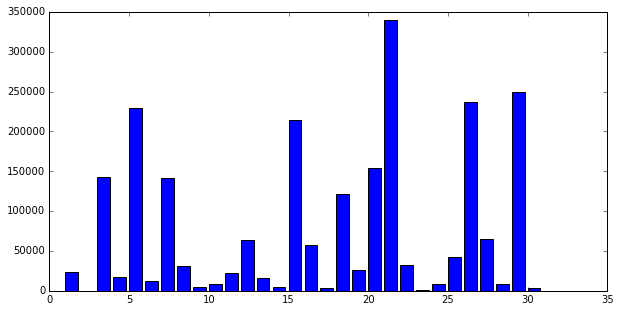

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(left=left, height=height, bottom=bottom)

In [11]:
c1 = Color(rgb=(1.0, 0, 0))
landcover_types = [ row[1]['Name'] for row in LandcoverTypes.iterrows() ]
colors_rgb = [Color(rgb=(1.00, 0.00, 0.00)), #1
              Color(rgb=(1.00, 0.92, 0.64)), #2
              Color(rgb=(0.00, 1.00, 0.00)), #3
              Color(rgb=(0.91, 0.80, 0.58)), #4
              Color(rgb=(0.00, 0.00, 0.00)), #5
              Color(rgb=(0.00, 0.76, 0.84)), #6
              Color(rgb=(0.00, 0.00, 0.00)), #7
              Color(rgb=(0.00, 0.00, 0.00)), #8
              Color(rgb=(0.00, 0.59, 0.26)), #9
              Color(rgb=(0.83, 0.73, 0.14)), #10
              Color(rgb=(0.00, 0.00, 0.00)), #11
              Color(rgb=(0.73, 0.99, 0.63)), #12
              Color(rgb=(0.00, 0.00, 0.00)), #13
              Color(rgb=(0.00, 0.00, 0.00)), #14
              Color(rgb=(0.00, 0.00, 0.00)),]#15

In [12]:
LandcoverTypes_colors = LandcoverTypes

In [13]:
LandcoverTypes_colors['Colors'] = pandas.Series([ c.get_hex_l() for c in colors_rgb ],
                                           index=LandcoverTypes.index)

#### handle missing landcover data

In [14]:
full_area = 775665.717

assume missing area is 'tree' landcover type

In [15]:
for index, row in landcover_area.iterrows():
    row_area = row['1':'15'].sum()
    area = 0
    if row_area <= full_area:
        area = full_area - row_area
    landcover_area.set_value(index, 'add_tree', area)

In [16]:
landcover_area_noadd = landcover_area

In [17]:
landcover_area['9'] = landcover_area['9'] + landcover_area['add_tree']

sort on landcover percentage

In [18]:
landcover_area_nosort = landcover_area

In [19]:
landcover_area.sort_values(by=['9', '2'],
                           ascending=[False, True],
                           inplace=True)

In [20]:
landcover_area['SiteID'].as_matrix()

array([23, 30, 22,  2, 17, 19, 11,  4,  9, 10, 25, 13, 24, 12, 14, 27,  1,
       28,  6, 18,  8, 15, 20,  7, 26, 16,  5,  3, 21, 29])

In [21]:
# all categories

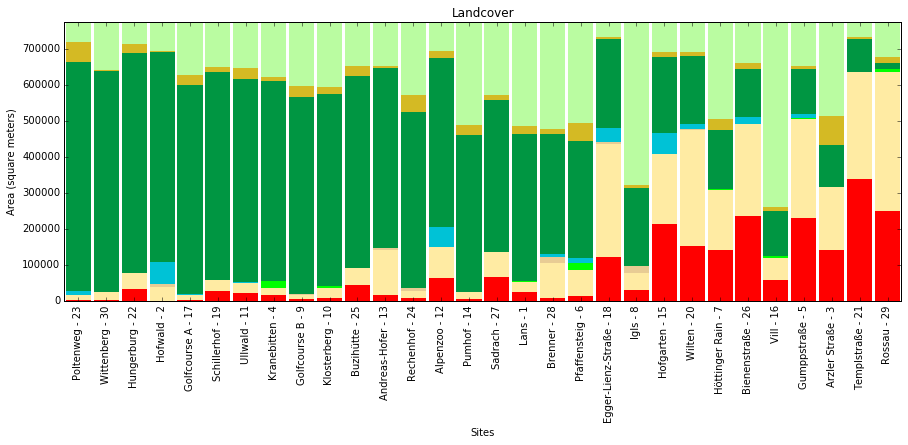

In [22]:
plt.figure(figsize=(15, 5))

bar_width = 0.9

ID = np.array([ n for n in range(len(landcover_area)) ])
SiteIDs = landcover_area['SiteID'].as_matrix()
left = ID + 0.05
height = np.zeros(len(landcover_area))
bottom = np.zeros(len(landcover_area))
for index, column in landcover_area.ix[:,'1':'15'].iteritems():
    height = column.as_matrix()
    plt.bar(left=left, 
            height=height, 
            bottom=bottom,
            width=bar_width,
            color=LandcoverTypes_colors['Colors'][int(index)],
            edgecolor=None,
            linewidth=0)
    bottom = bottom + height

plt.xlim(0, 30)
plt.ylim(0, full_area)
plt.xlabel('Sites')
plt.ylabel('Area (square meters)')
plt.title('Landcover')
xticks = ID + 0.5
xticklabels = landcover_area['SiteName'].as_matrix()
xticklabels = [ "{0} - {1}".format(xticklabels[i], SiteIDs[i]) for i in ID ]
plt.xticks(xticks, xticklabels, rotation='vertical')

## NDSI

In [23]:
IndexNDSI = db.fetch_as_pandas_df(table='IndexNDSI', fields=['Sound', 'ndsi_left', 'ndsi_right', 'biophony_left', 'biophony_right', 'anthrophony_left', 'anthrophony_right']).set_index('Sound')

In [24]:
ndsi = IndexNDSI.join(Sounds).join(Sites.drop('SiteID', axis=1), on='SiteID')

In [25]:
ndsi_collection1 = ndsi.groupby('ColID').get_group(1)

In [26]:
ndsi_collection1 = ndsi_collection1.rename(columns={"SiteID": "ID"})

In [27]:
ndsi_collection1_byID = ndsi_collection1.groupby('ID')

In [28]:
xticklabels = landcover_area['SiteName'].as_matrix()
xticklabels = [ "{0} - {1}".format(xticklabels[i], SiteIDs[i]) for i in ID ]

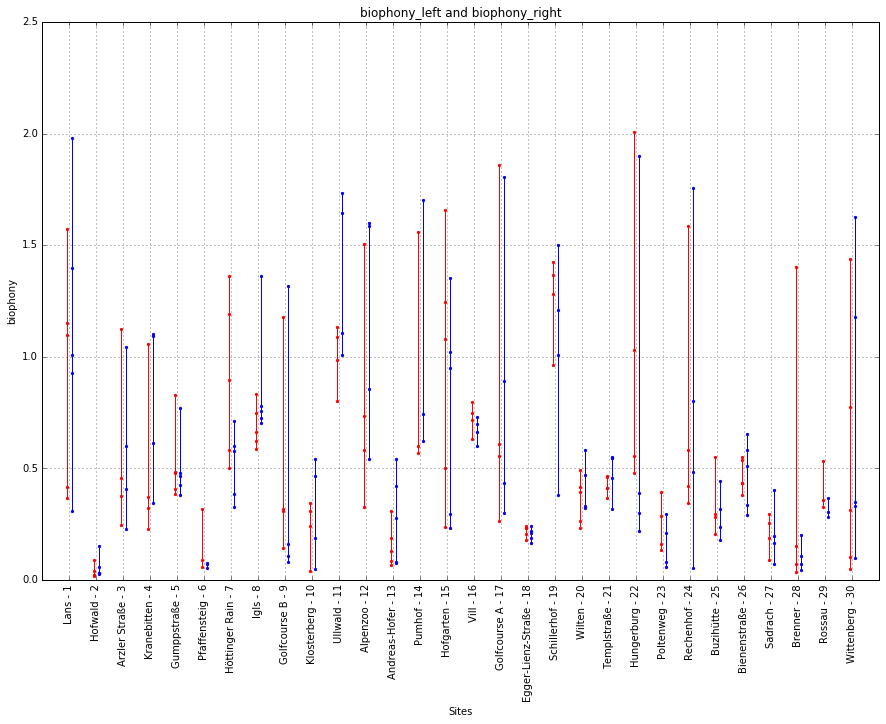

In [29]:
plt.figure(figsize=(15,10))
for name, group in ndsi_collection1_byID:
    x = (group['ID'].as_matrix() - 100) - 0.1
    y = group['biophony_left'].as_matrix()
    plt.plot(x, y, 'r-')
    plt.scatter(x, y, color='red', marker='.')
    x = (group['ID'].as_matrix() - 100) + 0.1
    y = group['biophony_right'].as_matrix()
    plt.plot(x, y, 'b-')
    plt.scatter(x, y, color='blue', marker='.')
plt.xlim(0, 31)
plt.ylim(0, 2.5)
plt.xlabel('Sites')
plt.ylabel('biophony')
plt.title('biophony_left and biophony_right')
xticks = [i for i in range(1, len(ndsi_collection1_byID)+1)]
xticklabels = Sites.sort_index()['SiteName'].as_matrix()
xticklabels = ["{0} - {1}".format(xticklabels[i-1], i) for i in xticks]
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.grid()